**General description of this notebook.**

There exists a python package for vortex dynamics named VortexFitting:

    - its reference is https://doi.org/10.1016/j.softx.2020.100604 (G. Lindner, Y. Devaux, S. Miskovic, 
      "VortexFitting: a post-processing fluid mechanics tool for vortex identification)

    - its GitHub page is https://github.com/guilindner/VortexFitting

    - its documentations page is https://guilindner.github.io/VortexFitting/
    
VortexFitting package has been integrated into PIVPY.
This tutorial shows how to work with VortexFitting package through PIVPY.

**How the PIVPY to VortexFitting conversion is implemented.**

Per Dr. Liberzon suggestion, VortexFitting has its own class `VelocityField` for storing velocity fields. One way to create a variable of this class is to read the field from a NetCDF file. Therefore, the function `pivpyTOvf()` from the `pivpy.interfacing` module of the PIVPY package takes a velocity field in the form of a PIVPY xarray Dataset, saves it to a NetCDF file (stored on the user's computer; the user can delete it afterwards), and reads the NetCDF file into a VortexFitting class object. From there, any function from the VortexFitting package will be able to work with it.

**Peculiarities of VortexFitting.**

VortexFitting is a Python package, it is not a Python library (i.e., you just run it from console as a 
piece of software - you do not use it like, for instance, `import numpy` in your code). Here is the work around
describing how to use VortexFitting as a library.

Either clone VortexFitting to your computer or go to its GitHub page. Navigate to the folder vortexfitting. There you will see a lot of .py files. Those files contain classes and functions of
VortexFitting. You can open each of those files, read the descriptions of the functions and see
what they can do. Once you have determined what functions (or class) you want to use in your code you
can use `import` command, but in a specific manner.

For example, I want to plot vorticity fields. I found that the file fitting.py contains the function `plot_fields()` that can plot vorticity. Then in my code, I type the following:
```
import vortexfitting.fitting as vfFitting
vfFitting.plot_fields(<the name of my field>, vorticity)
```

**Here is a custom made example with a velocity field that is also used to test the function pivpyToVf().**

In [ ]:
import pathlib
import importlib.resources
import numpy as np
import matplotlib.pyplot as plt
import vortexfitting.schemes as vfSchemes
import vortexfitting.fitting as vfFitting
import vortexfitting.detection as vfDetection
import vortexfitting.output as vfOutput
from netCDF4 import Dataset
from pivpy import io, graphics, interfacing as inter 

In [2]:
# This is just a fancy way to specify the path to the data within PIVPY package (this implementation
# is created by Dr.Liberzon).
# Ensure compatibility with different Python versions (3.9+ has 'files', 3.7 and 3.8 need 'path')
try:
    from importlib.resources import files
except ImportError:
    from importlib.resources import path as resource_path
# For Python 3.9+
try:
    path = files('pivpy') / 'data'
except NameError:
    # For Python 3.7 and 3.8
    with resource_path('pivpy', 'data') as data_path:
        path = data_path
# Convert to pathlib.Path if not already
path = pathlib.Path(path)

# Create an OpenPIV .txt file with velocity field (interTest.txt), put it into a folder and specify the path to it:
openpivTxtTestFile = path / "openpiv_txt" / "interTest.txt" 
# Think up a name for the future NetCDF file (which is created as an itermediate file as described above),
# think where it will be located and create such a path. To be totally clear: the NetCDF file
# testInterCreates_nc.nc does not exist yet. We have just created a name for it.
saveNcFile  = path / "interTest" / "testInterCreates_nc.nc"
# File with vortices created by VortexFitting:
saveVortexFile = path / "interTest" / "vortices.dat"
# Directory to save the plots to:
saveToDir = path / "interTest"

In [3]:
# Load the velocity field from the OpenPIV .txt as a PIVPY object:
d = io.load_openpiv_txt(str(openpivTxtTestFile))

In [ ]:
# Convert the PIVPY object to the VortexFitting object using the function pivpyTOvf() from pivpy.interfacing.
vfField = inter.pivpyTOvf(d,saveNcFile)

In [5]:
# As mentioned before, conversion of the PIVPY object to the VortexFitting object yields an auxiliary 
# NetCDF4 file. It is left to the user to decide what to do with the file. Just in case, this is a
# brief example of how to work with a NetCDF4 file.
# First, read the file:
nc = Dataset(str(saveNcFile))
# Second, access its data:
print("nc['grid_n']:\n{}".format(nc['grid_n'][:])) # the name of x coordinate in the VortexFitting class
print("\nnc['grid_z']:\n{}".format(nc['grid_z'][:])) # the name of y coordinate in the VortexFitting class
print("\nnc['velocity_n']:\n{}".format(nc['velocity_n'][:])) # the name of u velocity component in the VortexFitting class
print("\nnc['velocity_s']:\n{}".format(nc['velocity_s'][:])) # the name of v velocity component in the VortexFitting class
print("\nx coordinate nc-file shape: {}".format(nc['grid_n'].shape))
print("y coordinate nc-file shape: {}".format(nc['grid_z'].shape))
print("u velocity component nc-file shape: {}".format(nc['velocity_n'].shape))
print("v velocity component nc-file shape: {}".format(nc['velocity_s'].shape))


nc['grid_n']:
[ 0.94118  2.8235   4.7059   6.5882   8.4706  10.353   12.235   14.118
 16.      17.882   19.765   21.647   23.529   25.412   27.294   29.176
 31.059   32.941   34.824   36.706   38.588   40.471   42.353   44.235
 46.118   48.      49.882   51.765   53.647   55.529   57.412   59.294
 61.176   63.059   64.941   66.824   68.706   70.588   72.471   74.353  ]

nc['grid_z']:
[ 0.94118  2.8235   4.7059   6.5882   8.4706  10.353   12.235   14.118
 16.      17.882   19.765   21.647   23.529   25.412   27.294   29.176
 31.059   32.941   34.824   36.706   38.588   40.471   42.353   44.235
 46.118   48.      49.882   51.765   53.647   55.529   57.412   59.294  ]

nc['velocity_n']:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

nc['velocity_s']:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ..

Having obtained the VortexFitting object, you can apply any VortexFitting functions to it. Here are some examples.
**IMPORTANT: see the module \_\_main.py\_\_ in VortexFitting package for the exhaustive list of all the ways
you can work with VortexFitting**.

**Example 1**: obtaining the fields of u, v, x and y.

In [6]:
# IMPORTANT: the object of VortexFitting class does not store u, v, x and y as they are.
# There, u and v are, essentially, the fluctuating components of u and v velocity components (i.e,
# VortexFitting automatically subtracts the means from u and v); y coordinate is automatically 
# inversed by VortexFitting. For more information see the source code for class VelosityField (lines
# 87-108 under the "if file_type == 'piv_netcdf':" statement) in the classes.py module of 
# VortexFitting package.
print("vfField.u_velocity_matrix:\n{}".format(vfField.u_velocity_matrix[:]))
print("\nvfField.v_velocity_matrix:\n{}".format(vfField.v_velocity_matrix[:]))
print("\nvfField.x_coordinate_matrix:\n{}".format(vfField.x_coordinate_matrix[:]))
print("\nvfField.y_coordinate_matrix:\n{}".format(vfField.y_coordinate_matrix[:]))

vfField.u_velocity_matrix:
[[-1.36567925 -1.36567925 -1.36567925 ... -1.36567925 -1.36567925
  -1.36567925]
 [-1.75856725 -1.75856725 -1.75856725 ... -1.75856725 -1.75856725
  -1.75856725]
 [-2.0733985  -2.0733985  -2.0733985  ... -2.0733985  -2.0733985
  -2.0733985 ]
 ...
 [-1.08991275 -1.08991275 -1.08991275 ... -1.08991275 -1.08991275
  -1.08991275]
 [-1.39303803 -1.39303803 -1.39303803 ... -1.39303803 -1.39303803
  -1.39303803]
 [-1.06418175 -1.06418175 -1.06418175 ... -1.06418175 -1.06418175
  -1.06418175]]

vfField.v_velocity_matrix:
[[-11.8944825  -11.8944825  -11.8944825  ... -11.8944825  -11.8944825
  -11.8944825 ]
 [-10.39654625 -10.39654625 -10.39654625 ... -10.39654625 -10.39654625
  -10.39654625]
 [-10.57331775 -10.57331775 -10.57331775 ... -10.57331775 -10.57331775
  -10.57331775]
 ...
 [ -2.54497     -2.54497     -2.54497    ...  -2.54497     -2.54497
   -2.54497   ]
 [ -3.4852325   -3.4852325   -3.4852325  ...  -3.4852325   -3.4852325
   -3.4852325 ]
 [ 18.615097    18.

In [7]:
# Compare them to the original velocity and coordinate fields.
print("d['u'].values:\n{}".format(d['u'].values))
print("\nd['v'].values:\n{}".format(d['v'].values))
print("\nd.coords['x'].values:\n{}".format(d.coords['x'].values))
print("\nd.coords['y'].values:\n{}".format(d.coords['y'].values))

d['u'].values:
[[[nan]
  [nan]
  [nan]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 ...

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]]

d['v'].values:
[[[nan]
  [nan]
  [nan]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 ...

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]]

d.coords['x'].values:
[ 0.94118  2.8235   4.7059   6.5882   8.4706  10.353   12.235   14.118
 16.      17.882   19.765   21.647   23.529   25.412   27.294   29.176
 31.059   32.941   34.824   36.706   38.588   40.471   42.353   44.235
 46.118   48.      49.882   51.765   53.647   55.

**Example 2**: ploting colored contours of velocity and vorticity fields.

In [8]:
# To plot vorticity field, vorticity must be calculated first.
# VortexFitting offers three methods to approximate the derivatives going into the definition of
# vorticity (see the functions in the schemes.py module of VortexFitting package). They are 
# second_order_diff(vfield), least_square_diff(vfield) and fourth_order_diff(vfield). They way they
# can be used is exactly the same. Let me examplify their usage on fourth_order_diff(vfield) function.
# IMPORTANT to remember that this vorticity is based on the fluctuating velocity components.
vfFieldDerivative = vfSchemes.fourth_order_diff(vfField)
vorticity = vfFieldDerivative['dvdx'] - vfFieldDerivative['dudy']
print("Vorticity={}".format(vorticity))

Difference scheme: Fourth Order Scheme
Vorticity=[[ 0.00000000e+00  0.00000000e+00  1.57281924e-16 ...  1.57281924e-16
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00262048e-01  3.00262048e-01  3.00262048e-01 ...  3.00262048e-01
   3.00262048e-01  3.00262048e-01]
 ...
 [ 1.86952889e-01  1.86952889e-01  1.86952889e-01 ...  1.86952889e-01
   1.86952889e-01  1.86952889e-01]
 [ 0.00000000e+00  0.00000000e+00  5.89807217e-17 ...  5.89807217e-17
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.14563849e-16 ... -3.14563849e-16
   0.00000000e+00  0.00000000e+00]]


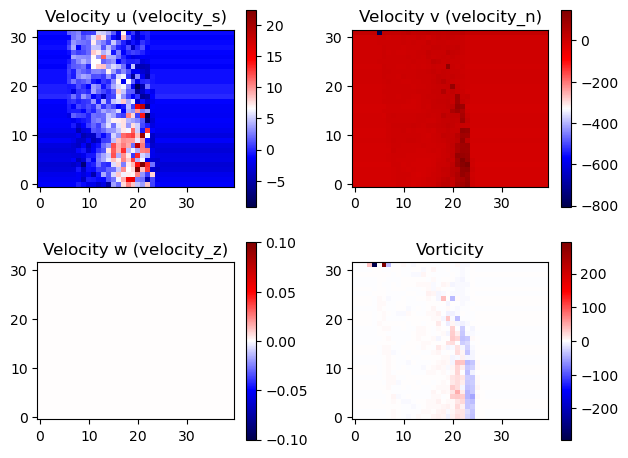

In [9]:
# The function plot_fields() from the module fitting.py of VortexFitting package offers a way to
# plot colored contours of vorticity.
# Run the cell and not the following important features of this function.
# 1) It plots not only colored contours of vorticity, but also colored contours of u,v and w fluctuating
# components of velocity. When the object of VortexFitting class is being created, VortexFiting demands
# w component. It wouldn't allow the absence of w component. w component may be None, but it must 
# exist. That's why the w plot is all white.
# 2) Even though the function plot_fields() accepts any "detection field" - not just vorticity - it
# will always call the "detection field" plot "vorticity".
# 3) Under the hood, the function plot_fields() makes use of the function plt.imshow() from matplotlib.
# The function plt.imshow() converts our fields to an image. Our fields - for instance, u field - 
# have each data point assigned to the center of the interrogation window. The size of the interrogation
# window might be, say, 16pix (or 32pix or 64pix). But the function plt.imshow() - when converting the
# field to the image - treats every interrogation window as a pixel. That is why the vertical and
# horizontal spans of the collored contours created by plot_fields() are smaller than the corresponding
# spans of our original fields.
# The flow setup I am using for this example has a rather peculiar upward flow along an inclined wall.
vfFitting.plot_fields(vfField, vorticity)

**Example 3**: ploting colored contour of vorticity field imposed on the field of the fluctuating velocity components.

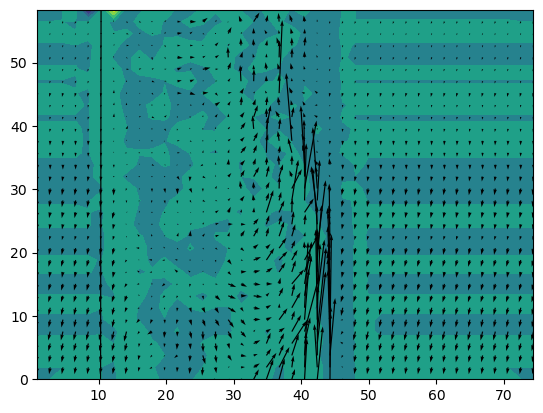

In [10]:
# The function plot_quiver() fro the fitting.py module of VortexFitting package offers a way to impose
# the colored contour of vorticity field on the plot of the fluctuating velocity components. Here is
# an example of how to use it.
# The flow setup I am using for this example has a rather peculiar upward flow along an inclined wall.
x2D, y2D = np.meshgrid(vfField.x_coordinate_matrix, vfField.y_coordinate_matrix)
vfFitting.plot_quiver(x2D, y2D, vfField.u_velocity_matrix, vfField.v_velocity_matrix, vorticity)

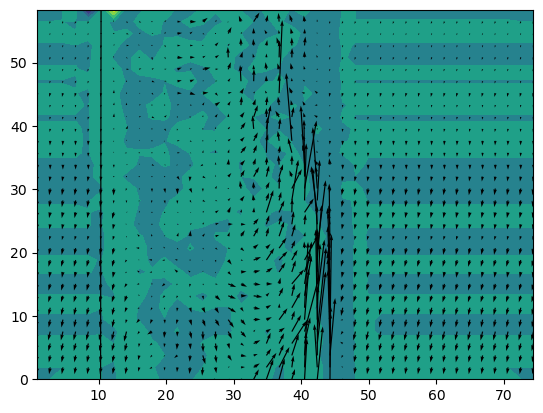

In [11]:
# To make sure VortexFitting plots the right field, let's do two tests.
# First, let's use matplotlib package to plot the field. The idea is that if another package results
# in the identical field, VortexFitting is validated.
plt.contourf(vorticity, extent=[x2D[0][0], x2D[0][-1], y2D[0][0], y2D[-1][0]])
plt.quiver(x2D, y2D, vfField.u_velocity_matrix, vfField.v_velocity_matrix)
plt.show()

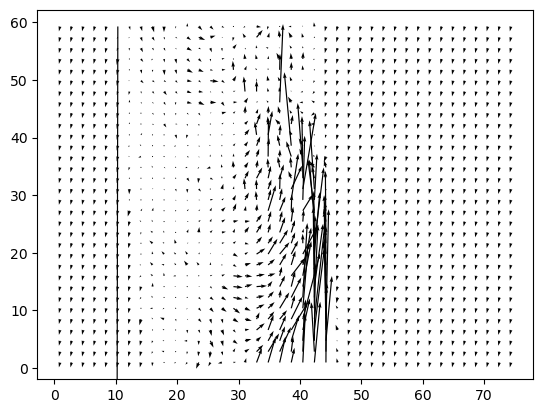

In [12]:
# Second, let's use matplotlib package to plot the original fields (the ones given by PIVPY object).
# The idea is the same - use another object to get the identical plot. Note, however, that the PIVPY
# object - as oppose to the VortexFitting object - stores the full velocity components, not just
# thir fluctuating parts.
x = d.coords['x'].values.flatten()
y = d.coords['y'].values.flatten()
X, Y = np.meshgrid(x, y)
Uvel = np.nan_to_num(d['u'].isel(t=0).values, copy=False); Uvel = np.subtract(Uvel,Uvel.mean())
Vvel = np.nan_to_num(d['v'].isel(t=0).values, copy=False); Vvel = np.subtract(Vvel,Vvel.mean())
plt.quiver(X, Y, Uvel.T, Vvel.T) 
plt.show()


c:\Users\nepomnyi\AppData\Local\miniconda3\envs\PIVPY_development\Lib\site-packages\pivpy\graphics.py:336: UserWarning: Warning: this function uses the first                frame, otherwise use: data.isel(t=N)
  warnings.warn(


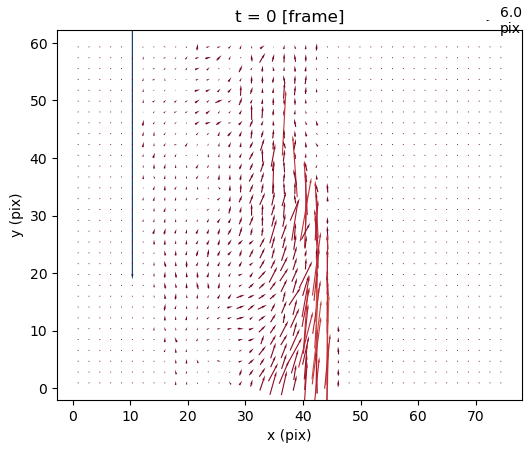

In [13]:
# And the same thing can be done using PIVPY native syntax:
graphics.quiver(d, arrScale=1) 
plt.show()

**Example 3**: vortex detection.

Detection method: Q criterion
Vortices found:  49
0 Processing detected swirling at (x, y) 7 2
1 Processing detected swirling at (x, y) 18 2
2 Processing detected swirling at (x, y) 25 2
3 Processing detected swirling at (x, y) 14 3
4 Processing detected swirling at (x, y) 6 4
5 Processing detected swirling at (x, y) 8 4
6 Processing detected swirling at (x, y) 12 4
7 Processing detected swirling at (x, y) 24 4
8 Processing detected swirling at (x, y) 16 5
9 Processing detected swirling at (x, y) 21 5
10 Processing detected swirling at (x, y) 23 6
11 Processing detected swirling at (x, y) 8 8
12 Processing detected swirling at (x, y) 22 8
13 Processing detected swirling at (x, y) 24 8
14 Processing detected swirling at (x, y) 6 9
15 Processing detected swirling at (x, y) 16 9
16 Processing detected swirling at (x, y) 11 11
17 Processing detected swirling at (x, y) 18 11
18 Processing detected swirling at (x, y) 21 11
19 Processing detected swirling at (x, y) 24 11
20 Processing detecte

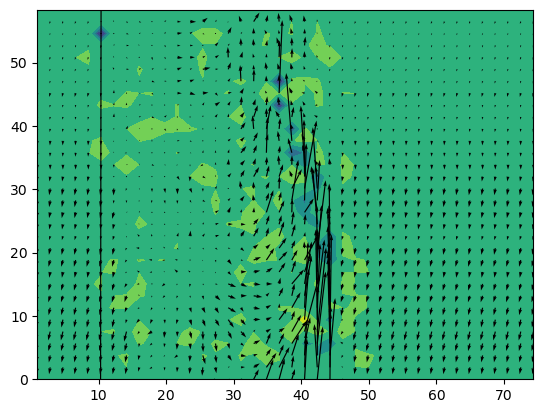

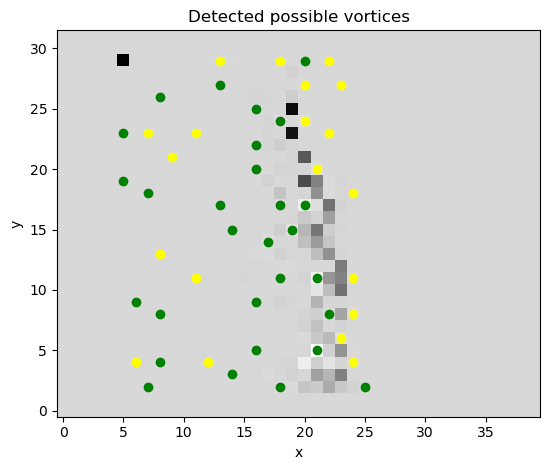

All the files in the saving directory saveToDir:
accepted_0.png
accepted_0.svg
linked_0.svg
meshed_0.png
testInterCreates_nc.nc
vortices.dat
vortices.txt


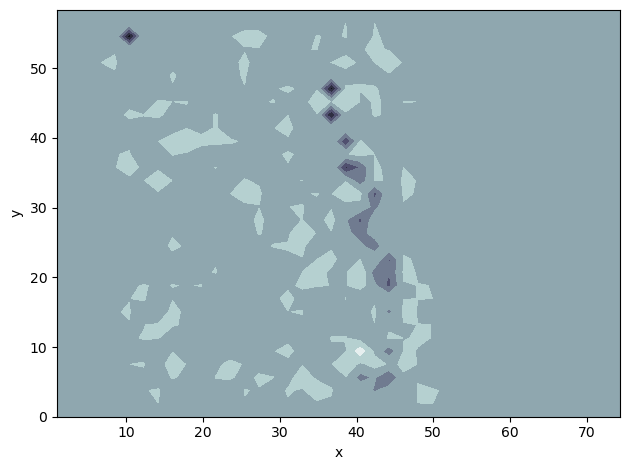

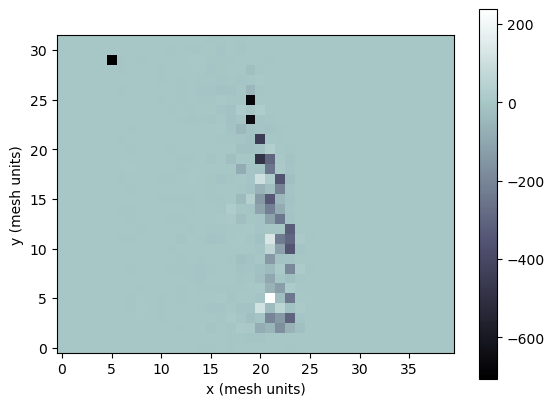

In [14]:
# Detect vortices using the Q criterion.
vortexDetect = vfDetection.calc_q_criterion(vfField)
sst = 0.1  # detection threshold
bs = 3     # box size
peaks = vfFitting.find_peaks(vortexDetect, sst, bs)
n_peaks = len(peaks[0]) if isinstance(peaks, (list, tuple)) and len(peaks) > 0 else 0
print('Vortices found:', n_peaks)

if n_peaks == 0:
    print('No peaks found at current threshold; skipping fitting/output cells.')
else:
    vortices_counterclockwise, vortices_clockwise = vfFitting.direction_rotation(vorticity, peaks)
    rmax = 100  # initial guess of the vortex radius
    ch = 0.75   # correlation threshold
    vortices = vfFitting.get_vortices(vfField, peaks, vorticity, rmax, ch)
    print('---- Accepted vortices ----')
    print(len(vortices))

    x_index, y_index, u_data, v_data = vfFitting.window(vfField, 0, 0, rmax)
    vfFitting.plot_quiver(x_index, y_index, u_data, v_data, vortexDetect)
    vfFitting.plot_detect(vortices_counterclockwise, vortices_clockwise, vortexDetect, 0)

    with saveVortexFile.open('w') as outfile:
        outfile.write('TITLE="Vortex characteristics evolution"\n')
        outfile.write('Variables="time","radius","gamma","xcenter","ycenter","u_advection","v_advection","correlation","vtheta"\n')
        outfile.write(f'DATASETAUXDATA Detection_method="Q criterion"\n')
        outfile.write(f'DATASETAUXDATA Scheme="fourth order"\n')
        outfile.write(f'DATASETAUXDATA Box_size="{bs}"\n')
        outfile.write(f'DATASETAUXDATA Detection_threshold="{sst}"\n')
        outfile.write(f'DATASETAUXDATA Rmax="{rmax}"\n')
        outfile.write(f'DATASETAUXDATA Correlation_threshold="{ch}"\n')
        outfile.write('DATASETAUXDATA Mean_file="mean field subtracted"\n')
        outfile.write('DATASETAUXDATA File_type="piv_netcdf"\n')
        outfile.write('ZONE T="0", SOLUTIONTIME=0\n')

    vfFitting.plot_accepted(vfField, vortices, vortexDetect, str(saveToDir), 0, 'png')
    vfOutput.write(vortices, str(saveToDir), 0)
    print('All the files in the saving directory saveToDir:')
    for path in saveToDir.iterdir():
        print(path.name)
